# T02: Real-World Data Pipelines & Analytics
Welcome to the Data Engineering workflow. In the real world, data is messy, physical bounds are violated, and string formats are a nightmare. Let's see how Chisa handles a dirty IoT dataset, and how failing to use Chisa would ruin your Data Science visualizations.

In [ ]:
# Setup the environment
try:
    import chisa
    print(f"Chisa version {chisa.__version__} is ready to go!")
except ImportError:
    print("Installing Chisa...")
    %pip install chisa
    import chisa
    print("Chisa installed successfully!")

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. The Nightmare IoT Dataset (Smart Grid Telemetry)
df_dirty = pd.DataFrame({
    'Timestamp': pd.date_range(start='2023-01-01', periods=6, freq='D'),
    'Sensor_ID': ['S-01', 'S-01', 'S-01', 'S-02', 'S-02', 'S-02'],
    'Status': ['ONLINE', 'ONLINE', 'OFFLINE', 'ONLINE', 'ONLINE', 'ONLINE'],
    # Messy energy strings (Joules, kWh, MMBtu)
    'Energy_Produced': ["5000 kWh", "18000000000 J", "NaN", "6000 kWh", "50 MMBtu", "5500 kWh"],
    # Extreme anomalies (-500 C) and mixed units
    'Core_Temp': ["90 C", "195.8 F", "200 C", "85 C", "-500 C", "88 C"] 
})

print("--- RAW, MESSY IoT TELEMETRY ---")
display(df_dirty)

--- RAW, MESSY IoT TELEMETRY ---


,Timestamp,Sensor_ID,Status,Energy_Produced,Core_Temp
0,2023-01-01,S-01,ONLINE,5000 kWh,90 C
1,2023-01-02,S-01,ONLINE,18000000000 J,195.8 F
2,2023-01-03,S-01,OFFLINE,NaN,200 C
3,2023-01-04,S-02,ONLINE,6000 kWh,85 C
4,2023-01-05,S-02,ONLINE,50 MMBtu,-500 C
5,2023-01-06,S-02,ONLINE,5500 kWh,88 C


### 1. Declarative Schema & Lifecycle Hooks
Instead of writing complex regex and for-loops, we define a strict Chisa Schema. We inject a `@pre_normalize` hook to filter out OFFLINE sensors before parsing begins.

In [2]:
import chisa as cs
from chisa import u

class SmartGridSchema(cs.Schema):
    # Target: Megawatt-hour
    total_energy: u.MegawattHour = cs.Field(
        source="Energy_Produced", 
        parse_string=True, 
        on_error='coerce', 
        round=2
    )
    # Target: Celsius. Cannot violate Absolute Zero.
    reactor_temp: u.Celsius = cs.Field(
        source="Core_Temp", 
        parse_string=True, 
        on_error='coerce',
        round=1
    )

    @cs.pre_normalize
    def filter_offline_sensors(cls, df):
        print("[Hook] Filtering out OFFLINE telemetry...")
        return df[df['Status'] != 'OFFLINE'].copy()

### 2. Vectorized Normalization
Watch Chisa intelligently parse strings, drop impossible physics (like `-500 C`), unify energy units into `MWh`, and keep your original metadata intact using `keep_unmapped=True`.

In [3]:
# Execute the pipeline using high-speed vectorization
clean_df = SmartGridSchema.normalize(
    df_dirty, 
    keep_unmapped=True, 
    drop_raw=True
)

print("\n--- CHISA STANDARDIZED PIPELINE DATA ---")
display(clean_df)

[Hook] Filtering out OFFLINE telemetry...

--- CHISA STANDARDIZED PIPELINE DATA ---


,Timestamp,Sensor_ID,Status,total_energy,reactor_temp
0,2023-01-01,S-01,ONLINE,5.00,90.0
1,2023-01-02,S-01,ONLINE,5.00,91.0
3,2023-01-04,S-02,ONLINE,6.00,85.0
4,2023-01-05,S-02,ONLINE,14.65,NaN
5,2023-01-06,S-02,ONLINE,5.50,88.0


### 3. The Impact: Analytics & Visualization
Why does this matter? Let's plot the average daily temperature. 
If we used the raw data and just stripped the letters using standard Python, the `-500 C` anomaly would cause our chart to collapse. Because Chisa safely neutralized it to `NaN`, our Data Science team gets perfectly clean insights.

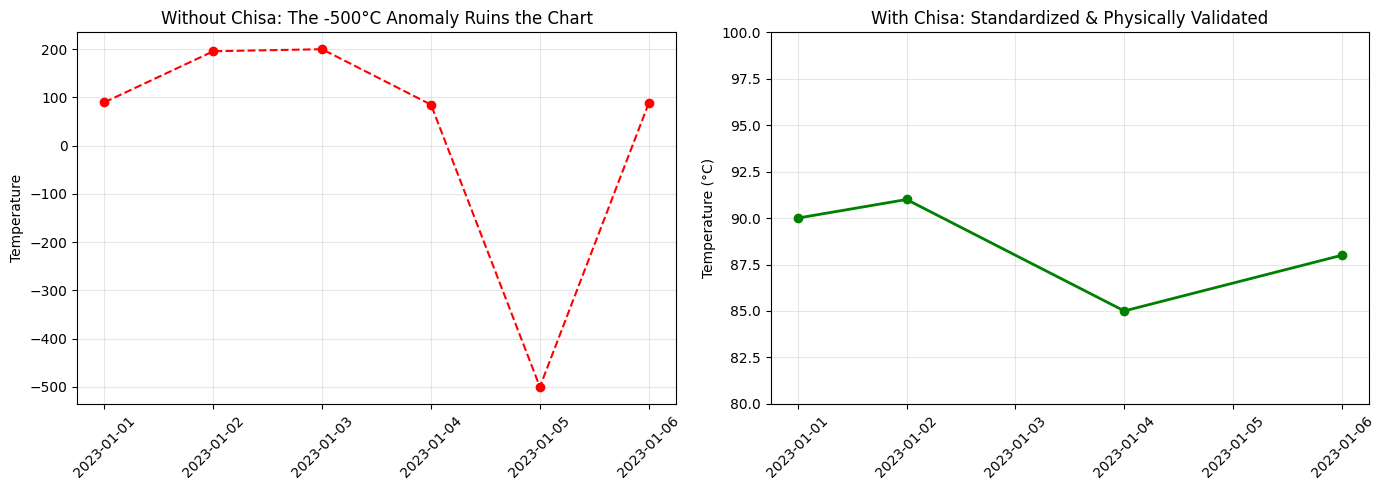

Conclusion:
Chisa successfully protected our downstream analytics from heterogeneous units (Fahrenheit vs Celsius) and impossible physical anomalies (-500 C).


In [4]:
# A quick simulation of what would happen WITHOUT Chisa (naive text stripping)
naive_temp = pd.to_numeric(df_dirty['Core_Temp'].str.extract(r'([-+]?\d*\.?\d+)')[0])

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: The Nightmare (Without Chisa)
ax[0].plot(df_dirty['Timestamp'], naive_temp, marker='o', color='red', linestyle='--')
ax[0].set_title("Without Chisa: The -500°C Anomaly Ruins the Chart")
ax[0].set_ylabel("Temperature")
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(True, alpha=0.3)

# Plot 2: The Clean Reality (With Chisa)
# We dropna() just for the plot line to connect smoothly
clean_plot_data = clean_df.dropna(subset=['reactor_temp'])
ax[1].plot(clean_plot_data['Timestamp'], clean_plot_data['reactor_temp'], marker='o', color='green', linewidth=2)
ax[1].set_title("With Chisa: Standardized & Physically Validated")
ax[1].set_ylabel("Temperature (°C)")
ax[1].set_ylim(80, 100) # Realistic operating bounds
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Conclusion:")
print("Chisa successfully protected our downstream analytics from heterogeneous units (Fahrenheit vs Celsius) and impossible physical anomalies (-500 C).")